<a href="https://colab.research.google.com/github/MevrouwHelderder/final_assignment/blob/main/Final_Assignment_Energy_production_and_consumption_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final assignment - Energy production and consumption
For this assignment I want to answer the following questions, using datasets created by Our World in Data: 

* What is the biggest predictor of a large CO2 output per capita of a country?
* Which countries are making the biggest strides in decreasing CO2 output?
* Which non-fossil fuel energy technology will have the best price in the future?


# Preparing the basics

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
%load_ext google.colab.data_table

In [2]:
path_base = "https://raw.githubusercontent.com/MevrouwHelderder/final_assignment/main/"

paths = {
    "energy_total": path_base + "owid-energy-data.csv",
    "co2_greenhouse": path_base + "owid-co2-data.csv",
    "net_zero_pledge": path_base + "net-zero-targets.csv",
    "milk_consumption_df": path_base + "per-capita-milk-consumption.csv",
    "milk_production_df": path_base + "milk-production-tonnes.csv",
    "meat_supply_df": path_base + "meat-supply-per-person.csv",
    "meat_production_df": path_base + "global-meat-production.csv",
    "food_foodprints_df": path_base + "food-footprints.csv",
    "aviation_per_capita_df": path_base + "per-capita-domestic-aviation-km.csv",
    "costs_df": path_base + "costs-of-66-different-technologies-over-time.csv",
}

dataframes = {}

for key, value in paths.items():
    dataframes[key] = pd.read_csv(value)

energy_total_df = dataframes["energy_total"]
co2_greenhouse_df = dataframes["co2_greenhouse"]
net_zero_pledge_df = dataframes["net_zero_pledge"]
milk_consumption_df = dataframes["milk_consumption_df"]
milk_production_df = dataframes["milk_production_df"]
meat_supply_df = dataframes["meat_supply_df"]
meat_production_df = dataframes["meat_production_df"]
food_foodprints_df = dataframes["food_foodprints_df"]
aviation_km_df = dataframes["aviation_per_capita_df"]
costs_df = dataframes["costs_df"]

# Question 1: What is the biggest predictor of a large CO2 output per capita of a country?

For this question I am going to look at several factors that I think could be contributing to a large CO2 output.
I am going to see if there is a correlation between them and the CO2 output per capita of countries:

* The GDP 
* Types of energy used
* Types of food consumed
* Amount of commercial flights

For all factors I am going to look at the use per capita. Or, in simpler terms, the use per person.

# Energy vs Electricity

When thinking about energy we usually think about the electricity used. And that is not wrong but energy is used for more than just generating electricity. It is, for example, also used for heating and transport.


For example, let's look at the Netherlands through the years.
What percentage of the total energy used was used for generating electricity?
And since the Netherlands is known to heavily rely on gas for heating and cooking, let's also look at Denmark, a country where cooking and heating are usually done with electric stoves.

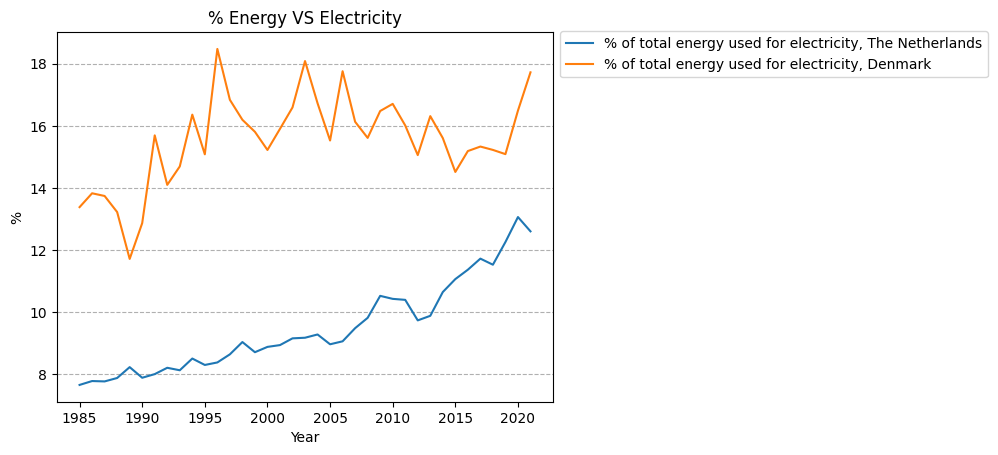

In [3]:
netherlands = (energy_total_df[energy_total_df["country"]=="Netherlands"]).loc[:,["year","electricity_share_energy"]].dropna()
denmark = (energy_total_df[energy_total_df["country"]=="Denmark"]).loc[:,["year","electricity_share_energy"]].dropna()

fig, ax = plt.subplots()

nether_year = netherlands["year"]
nether_energy = netherlands["electricity_share_energy"]
den_year = denmark["year"]
den_energy = denmark["electricity_share_energy"]

ax.plot(nether_year, nether_energy, label="% of total energy used for electricity, The Netherlands")
ax.plot(den_year, den_energy, label="% of total energy used for electricity, Denmark")

ax.set_title("% Energy VS Electricity")
ax.set_xlabel("Year")
ax.set_ylabel("%")
ax.grid(axis='y', linestyle='--')
ax.legend(loc='center left', bbox_to_anchor=(1,0.94))
plt.show()

In the plot above you can see the percentage of the total used energy that is used for generating electricity. 
You can clearly see the difference between the countries. In Denmark a bigger share of the total energy use goes to the production of electricty.

However, in both countries the share is still less than 20%. That means that more than 80% of the total energy a country consumes is used for other things.

That is why for the following analysis I will look at the total energy used, not at the electricity used.



# Fuel use

To see if the use of certain fuels is indicative of a high CO2 output I will make a dataframe that shows the what percentages of the total energy consumption are made up by the different energy sources.

I will first look at low-carbon sources vs high-carbon sources. If needed I can specify more so I will keep the data on the singular sources for now.


In [4]:
# singular sources:
fuel_list = [
    "coal",
    "oil",
    "gas",
    "wind",
    "solar",
    "hydro",
    "nuclear",
    "other_renewables",
    "low_carbon",
    "fossil",
]

# lists with columns bases
fuel_share_base_list = ["_share_energy"]

# Columnnames that don't need to be pieced together
fuel_complete_columns_list = ["country", "year", "iso_code", "energy_per_capita"]

# Function to create the needed dataframe out of the original
def make_df(original_df, topic_list, base_list, columns_to_keep_list, per_capita=False):
    new_columns = columns_to_keep_list
    base_list = base_list

    for topic_item in topic_list:
        for base_item in base_list:
            new_columns.append(topic_item + base_item)

    new_df = original_df[new_columns].copy()

    return new_df


# Make df
fuel_use = make_df(
    energy_total_df,
    fuel_list,
    fuel_share_base_list,
    fuel_complete_columns_list,
    per_capita=False,
)

# show only the true, singular, countries
fuel_use = fuel_use[~fuel_use["iso_code"].isnull()].copy()

# Setting the index and dropping what is not needed
fuel_use = fuel_use.set_index("year")
fuel_use.index = pd.to_datetime(fuel_use.index, format="%Y", errors="coerce")

fuel_use = fuel_use.drop(["iso_code"], axis=1)
fuel_use = fuel_use.dropna()

# CO2 emission:

Sometimes when talking about CO2 the term **'Greenhouse gasses'** is used.

Greenhouse gasses is a term used for several gasses, mostly carbon dioxide (=CO2), methane, nitrous oxide, hydrochlorofluorocarbons (HCFCs), hydrofluorocarbons (HFCs) and ozone. 

Because in general they can be compared to CO2 they are usually measured in CO2 equivalents. Meaning they are scaled in such a way that their impact is the same as that of CO2.
This way we can talk about CO2, making it more clear.


---

Another term you can encounter is **Land Use Change**.

Land-use-change is the change of the use of land. This can be, for example, deforestation in order for cattle or crops to grow.

This can have a major impact on the CO2 emission since trees and plants remove CO2 from the atmosphere. You can imagine the impact when you not only remove the trees but also replace them with industry that emitts CO2!

---
When looking at the CO2 output of a country it is important to recognise the amount of CO2 emitted in total and the amount of CO2 emitted for own use.
The difference lies in the fact that a lot of countries import goods from other countries. 
This means that they themselves not "produce" the CO2 but they are responsible for that CO2 emitted. After all, if they did not buy those goods that CO2 would not have been emitted.

I will look at the consumption of CO2 per capita. This means the emission of CO2 per capita, corrected for trade.

In [5]:
co2_df = co2_greenhouse_df.loc[
    :,
    [
        "country",
        "year",
        "iso_code",
        "population",
        "gdp",
        "consumption_co2",
        "consumption_co2_per_capita",
        "co2",
        "co2_per_capita",
    ],
]

# show only the true, singular, countries
co2_df = co2_df[~co2_df["iso_code"].isnull()].copy()

# Add a column with the gdp per capita to totals
co2_df["gdp_per_capita"] = (co2_df["gdp"] / co2_df["population"]).round(3)

# Setting the index and dropping what is not needed
co2_df = co2_df.set_index("year")
co2_df.index = pd.to_datetime(co2_df.index, format="%Y", errors="coerce")

co2_df = co2_df.drop(["iso_code", "gdp", "population"], axis=1)

# Renaming
co2_df = co2_df.rename(
    columns={
        "consumption_co2_per_capita": "total_co2_consumed_per_capita",
        "gdp_per_capita": "gdp_per_capita",
        "consumption_co2": "total_co2_consumed",
        "co2": "total_co2_emitted",
        "co2_per_capita": "total_co2_emitted_per_capita",
    }
)

# Food

Let's first look at what foodsources are responsible for the most CO2 emission and use these in our further analysis.

The way the CO2 emission of food sources is measured is by looking at the total output per kilogram. This means the total impact of all stages of the production process. So also, for example, the impact of land use change needed to produce the food.

<Axes: ylabel='Entity'>

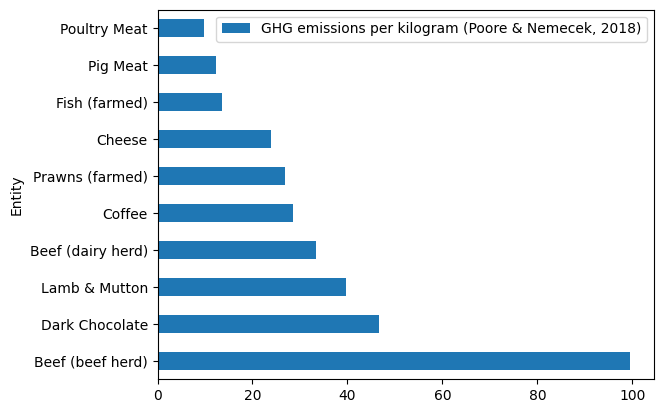

In [6]:
top_ten_food_co2 = food_foodprints_df.sort_values('GHG emissions per kilogram (Poore & Nemecek, 2018)', ascending=False).head(10)
top_ten_food_co2.plot.barh( 'Entity', 'GHG emissions per kilogram (Poore & Nemecek, 2018)')

We can see that most of the food sources with a high carbon foodprint are meat- or dairy products.

The two non-animal products, coffee and dark chocolate, have a high greenhouse gass emission because of the deforestation during the production.

However, both coffee and chocolate are usually not eaten in the same quantities as the other products in the top 10 and therefore probably don't have a high impact per capita.

It is clear that when looking at food as a possible indicator of a high CO2 emission we should look at the production of animal based foodsources.

So how much of those are being consumed in a country?

In [7]:
consumption = pd.merge(
    meat_supply_df, milk_consumption_df, on=["Entity", "Code", "Year"], how="outer"
)
consumption = consumption.rename(
    columns={
        "Entity": "country",
        "Year": "year",
        "Meat, total | 00002943 || Food available for consumption | 0645pc || kilograms per year per capita": "meat_consumption_per_capita_(kg per year)",
        "Milk - Excluding Butter | 00002848 || Food available for consumption | 0645pc || kilograms per year per capita": "dairy_consumption_per_capita_(kg_per_year)",
    }
)
# Setting the index
consumption = consumption.set_index("year")
consumption.index = pd.to_datetime(consumption.index, format="%Y", errors="coerce")
# show only the true countries, not the combinations like continents
consumption = consumption[~consumption["Code"].isnull()].copy()
consumption = consumption.drop(["Code"], axis=1)

# Aviation

I will look at the total amount of km flown per capita.

In [8]:
aviation = aviation_km_df.rename(
    columns={
        "Entity": "country",
        "Year": "year",
        "Per capita domestic RPKs": "aviation_km_per_capita",
    }
)
# show only the true countries, not the combinations like continents
aviation = aviation[~aviation["Code"].isnull()].copy()

aviation = aviation.drop(["Code"], axis=1)
aviation = aviation.set_index("year")
aviation.index = pd.to_datetime(aviation.index, format="%Y", errors="coerce")

transport_food = pd.merge(aviation, consumption, on=["country", "year"], how="outer")

# Combining it into a dataframe that can be used for comparison

In [9]:
everything = pd.merge(co2_df, transport_food, on=["country", "year"], how="outer")
everything = pd.merge(
    everything,
    fuel_use[["country", "fossil_share_energy"]],
    on=["country", "year"],
    how="outer",
)

# Rows without the co2 consumed per capita present are no use
everything = everything[~everything["total_co2_consumed_per_capita"].isna()]

# Let's look at the last 20 years
everything_2000 = everything[(everything.index.year >= 2000)]

# Function to resample and interpolate
def prepare(df):
    df.index = pd.to_datetime(df.index, format="%Y", errors="coerce")
    df = (
        df.groupby("country")
        .resample("YS")
        .mean(numeric_only=True)
        .interpolate(method="linear")
    )
    df.reset_index(inplace=True)
    df.set_index("year", inplace=True)

    return df


everything_2000_interpolated = prepare(everything_2000).dropna()

# Can I find a correlation between any of the factors and the CO2 output per Capita?

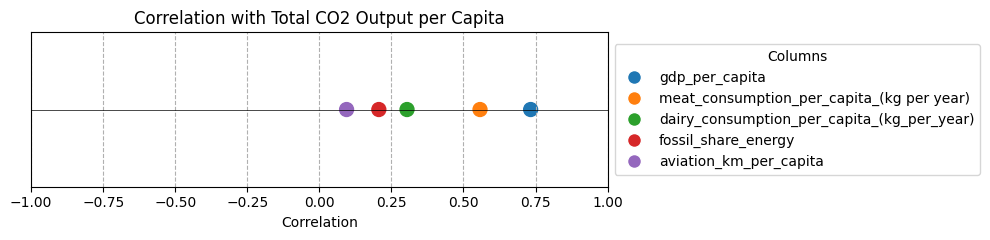

In [10]:
# Calculating correlations
# List of columns to calculate correlations
columns = [
    "gdp_per_capita",
    "meat_consumption_per_capita_(kg per year)",
    "dairy_consumption_per_capita_(kg_per_year)",
    "fossil_share_energy",
    "aviation_km_per_capita",
]

# Initialize a list to store the correlation results
correlation_results_emission = []
p_value_results_emission = []

# Iterate over each column
for column in columns:
    correlation, p_value = pearsonr(
        everything_2000_interpolated["total_co2_emitted_per_capita"],
        everything_2000_interpolated[column],
    )

    correlation_results_emission.append((column, correlation, p_value))
    p_value_results_emission.append((column, p_value))

# Sort the correlation results by correlation value
correlation_results_emission.sort(key=lambda x: x[1], reverse=True)
p_value_results_emission.sort(key=lambda x: x[1])

# Extract the column names, correlation values, and p-values from the results
columns_emission = [result[0] for result in correlation_results_emission]
correlation_values_emission = [result[1] for result in correlation_results_emission]
p_values_emission = [result[1] for result in p_value_results_emission]

# Create a figure and two subplots
fig, ax = plt.subplots(figsize=(10, 2.5))

colors = ["C0", "C1", "C2", "C3", "C4"]

y_emission = np.zeros(len(columns_emission))

scatter = ax.scatter(correlation_values_emission, y_emission, c=colors, s=100)

ax.tick_params(axis="y", left=False, labelleft=False)
ax.axhline(0, color="black", linewidth=0.5)
ax.grid(axis="x", linestyle="--")

ax.set_xlim(-1, 1)
ax.set_title("Correlation with Total CO2 Output per Capita")
ax.set_xlabel("Correlation")

legend_elements2 = [
    plt.Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label=column,
        markerfacecolor=color,
        markersize=10,
    )
    for column, color in zip(columns_emission, colors)
]
ax.legend(
    handles=legend_elements2,
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    title="Columns",
)

plt.tight_layout()
plt.show()


What do we see?

* **gdp**: The correlation coefficient of 0.73 indicates a strong positive correlation between GDP per capita and the total energy per capita consumed. This suggests that as GDP per capita increases, there is a tendency for higher energy consumption per capita. The p-value of 0.0 indicates that this correlation is highly statistically significant, providing strong evidence of the relationship.

* **meat_consumption**: The correlation coefficient of 0.56 suggests a moderate positive correlation between meat consumption per capita and the total energy per capita consumed. This implies that higher meat consumption is associated with higher energy consumption. The p-value of 2.34e-202 indicates that this correlation is highly statistically significant

* **dairy_consumption**: The correlation coefficient of 0.30 indicates a weak positive correlation between dairy consumption per capita and the total energy per capita consumed. This suggests that higher dairy consumption is somewhat associated with higher energy consumption. The p-value of 3.48e-54 suggests that this correlation is statistically significant.

* **fossil energy**: The correlation coefficient of 0.21 indicates a weak positive correlation between the share of fossil energy and the total energy per capita consumed. This implies that a higher share of fossil energy in the energy mix is somewhat associated with higher energy consumption. The p-value of 3.11e-25 suggests that this correlation is statistically significant.

* **aviation**: The correlation coefficient of 0.09 suggests a weak positive correlation between aviation kilometers traveled per capita and the total energy per capita consumed. This indicates that higher levels of aviation activity are somewhat associated with higher energy consumption. The p-value of 2.51e-06 suggests that this correlation is statistically significant.

# Conclusion: 
The biggest predictor of a large CO2 output per capita seems to be the GDP.

Which makes sense. A higher quality of living requires more energy. Not only for the basics as cooking, heating and electricity but also for the production of goods, for the production of a more varied diet and for travel.

The other factors do seem correlated, especially an animal-based diet so they absolutely are things we need to keep in mind when trying to lower our CO2 output.


# Question 2: Which countries are making the biggest strides in decreasing CO2 output?

Let's first look the change in CO2 output over the past 20 years. 
As stated above, we are going to look at the output per capita, corrected for trade. So the CO2 consumed per person, for own use.


In [11]:
grouped = everything_2000_interpolated.groupby("country")

# Find the first and last entry per group and calculate the relative change
# For CO2 output
first_consumption = grouped.first()["total_co2_consumed_per_capita"]
last_consumption = grouped.last()["total_co2_consumed_per_capita"]
relative_change_consumption = (
    ((last_consumption - first_consumption) / first_consumption) * 100
).round(3)

# For GDP
first_gdp = grouped.first()["gdp_per_capita"]
last_gdp = grouped.last()["gdp_per_capita"]
relative_change_gdp = (((last_gdp - first_gdp) / first_gdp) * 100).round(3)

# Make a df with the changes per country
change_df = pd.DataFrame(
    {
        "change_CO2_output_per_capita_(%)": relative_change_consumption,
        "change_gdp_per_capita_(%)": relative_change_gdp,
    }
)

# Find the biggest changers
biggest_consumption_changers = (
    relative_change_consumption.sort_values(ascending=True).head(5).astype(str) + " %"
)

print(
    "The countries that showed the biggest decrease in CO2 emission per capita, corrected for trade, since 2020:"
)
print(biggest_consumption_changers)

The countries that showed the biggest decrease in CO2 emission per capita, corrected for trade, since 2020:
country
Venezuela         -79.809 %
Portugal          -56.617 %
Greece            -46.478 %
United Kingdom    -45.381 %
Finland           -43.131 %
Name: total_co2_consumed_per_capita, dtype: object


We can see that there are countries that managed to decrease their CO2 output per capita.

However, the biggest strides are probably being made by countries that managed to **decrease CO2 output per capita** while also **increasing GDP**. 


Because that means that they not only decreased their output but also found a way to counteract  the growth in CO2 emissions that come with a rising standard of living.

Let's look at specifically the output per capita and the GDP and let's rank them based on those two aspects.


In [12]:
# Show countries that lowered CO2 emission (change < 0) and increase GDP (change > 0)
biggest_strides = change_df[
    (change_df["change_CO2_output_per_capita_(%)"] < 0)
    & (change_df["change_gdp_per_capita_(%)"] > 0)
].copy()
biggest_strides["total_rank"] = (
    biggest_strides["change_CO2_output_per_capita_(%)"].rank(ascending=True)
    + biggest_strides["change_gdp_per_capita_(%)"].rank(ascending=False)
).rank()

display(biggest_strides.sort_values("total_rank"))

,change_CO2_output_per_capita_(%),change_gdp_per_capita_(%),total_rank
country,,,
Portugal,-56.617,51.589,1.0
Jamaica,-11.523,266.437,3.0
South Africa,-12.372,166.736,3.0
United Kingdom,-45.381,35.093,3.0
Czechia,-19.380,113.056,5.5
Ukraine,-4.223,563.781,5.5
Slovakia,-20.228,68.212,7.5
Sweden,-38.570,30.274,7.5
Finland,-43.131,10.299,9.5


There are sixteen countries that managed to lower their CO2 output per capita while increasing their GDP per capita.


However, I believe that using this to prove they are making big strides might be oversimplified. 

Yes, they are absolutely making strides but more is needed to truly make big strides, now and in the future.



# Pledges and Targets

So let's also look at any targets countries set when it comes to lowering their CO2 emissions.

It is important to recognize that a pledge is nothing more or less than a promis; it needs to be put in law.

Only when it has become a law a country has the true obligation to work towards their goal.

For this assignment I will look at: 
* does a country have a goal?
* what is the pledged year
* what is the status of the goal

It is also important to know that not all countries have used the same terms and conditions. Some include aviation, some don't. Some allow for carbon offset, some don't.
For the sake of compactness I will not look at the specific terms and conditions but I will explain a tiny bit more about carbon offset.

# Carbon offset vs low emission

Carbon offset can be seen, simply put, as compensating for CO2 emitted by creating nature that will reabsorb CO2.

 If there is enough nature to compensate for the emitted CO2 the end result could be 0. However, this can not be the only solution for lowering CO2 for two reasons: 
 * There is an end to the amount of nature we can create
 * It does not help towards a change in mentality when it comes to CO2

 
 So when the limit of trees to plant has been reached and we do not have a changed mentality on CO2 and consumerism we are back where we started.

 That doesn't mean that carbon offset is wrong but it is important to take it into account when further looking into the pledges and goals countries make.

# What happens with our competion for the biggest stride when we also look at any pledges and targets on net-zero emission?


In [13]:
net_zero_pledge = net_zero_pledge_df.loc[
    :, ["Entity", "Year", "Status of net-zero target"]
].copy()
net_zero_pledge = net_zero_pledge.rename(
    columns={
        "Entity": "country",
        "Year": "pledged_year",
        "Status of net-zero target": "status",
    }
)

# Include the data on pledges
even_bigger_strides = pd.merge(change_df, net_zero_pledge, on="country", how="outer")

# Show countries that have reached their target
achieved = even_bigger_strides[even_bigger_strides["status"] == "Achieved"]
display(achieved)

,country,change_CO2_output_per_capita_(%),change_gdp_per_capita_(%),pledged_year,status
9,Benin,89.565,86.586,2000.0,Achieved
16,Cambodia,504.113,55.156,2000.0,Achieved
62,Madagascar,19.136,-7.832,2010.0,Achieved
122,Bhutan,NaN,NaN,2000.0,Achieved
124,Guinea-Bissau,NaN,NaN,2030.0,Achieved
125,Guyana,NaN,NaN,2019.0,Achieved
127,Liberia,NaN,NaN,2000.0,Achieved


There are seven countries that have already reached their net-zero target.

Congratulations to them! But since they are either small, fairly underdeveloped and/or have no data on GDP or CO2 output I will not include them in my search for the biggest stride.


---


**So let's find countries that have:**
* decreased their CO2 output
* increased their GDP
* set a net-zero goal

In [14]:
the_biggest_strides = even_bigger_strides[
    (even_bigger_strides["change_CO2_output_per_capita_(%)"] < 0)
    & (even_bigger_strides["change_gdp_per_capita_(%)"] > 0)
    & (~even_bigger_strides["status"].isna())
]
display(the_biggest_strides)

,country,change_CO2_output_per_capita_(%),change_gdp_per_capita_(%),pledged_year,status
2,Australia,-9.489,9.577,2050.0,Pledge
34,Finland,-43.131,10.299,2035.0,In policy document
49,Israel,-24.964,25.748,2050.0,Pledge
85,Portugal,-56.617,51.589,2050.0,In policy document
95,South Africa,-12.372,166.736,2050.0,Pledge
99,Sweden,-38.570,30.274,2045.0,In law
110,Ukraine,-4.223,563.781,2060.0,In policy document
111,United Arab Emirates,-30.213,3.172,2050.0,Pledge
112,United Kingdom,-45.381,35.093,2050.0,In law


We see nine countries.
When looking at the status of their pledges we see the following:

* Four countries have pledges but are not further in the process.
* Three countries are in the process of creating laws based on their pledges.
* Two countries have made laws based on their pledges.

The two countries that have not only lowered their CO2 output and raised their GDP but have also made laws regarding net-zero CO2 emission are: 

* United Kingdom
* Sweden




# Conclusion: who has made the biggest of strides when it comes to decreasing CO2 output?

Sweden has pledged to reach their net-zero goal in 2045 while the UK has pledged 2050 I deem of the competiton: 

**Sweden!**


# Question 3: which non-fossil fuel energy technology will have the best price in the future?

I would like to start with saying that I had a hard time finding the right dataset(s).
Since part of the assignment was that I could only use data from OWID I scoured their website for any information on the prices of non-fossil fuel energy technology.
The only thing I could find was [this](:https://ourworldindata.org/grapher/costs-of-66-different-technologies-over-time?tab=table ).

If I have overlooked anything, please let me know!


---



In the last decade the price of renewable fuels has falled dramatically. Where the use of renewable energy was once something exclusive and unobtainable it is now often even cheaper than fossil-fueled energy.

The biggest reason for this is that, in short, the technology behind the renewable energy sources follows a learning curve. 

Meaning that when we improve the technologies behind the renewables it gets cheaper to produce them. Producing products on a bigger scale also typically also lowers the price. 

Both contribute to an exponential decrease.


Where renewable energy gets cheaper over time, fossil fueled energy gets more expensive over time, mainly because of two reasons: 
There is only so much we can still learn and improve when it comes to fossil fuels.
Fossil fuels are not infinite and when a product gets harder and harder to come by the prices rise.

That renewable energy is the way forwards is no surprise. But let's see what the prices of the technologies behind the renewable energy sources are going to do in the future!


In [15]:
# Look at the entities to find the renewable energy sources:
costs_df["Entity"].unique()

array(['Acrylic fiber', 'Acrylonitrile', 'Aluminum', 'Ammonia', 'Aniline',
       'Automotive (US)', 'Beer (Japan)', 'Benzene', 'Bisphenol A',
       'CCGT Power', 'Caprolactam', 'Carbon black', 'Carbon disulfide',
       'Concentrating Solar', 'Corn (US)', 'Crude Oil', 'Cyclohexane',
       'DNA Sequencing', 'DRAM', 'Electric Range', 'Ethanol (Brazil)',
       'Ethanolamine', 'Ethylene', 'Formaldehyde',
       'Free Standing Gas Range', 'Geothermal Electricity',
       'Hard Disk Drive', 'Hydrofluoric acid', 'Isopropyl alcohol',
       'Laser Diode', 'Low-density polyethylene', 'Magnesium',
       'Maleic anhydride', 'Methanol', 'Milk (US)',
       'Monochrome Television', 'Motor Gasoline', 'Neoprene rubber',
       'Nuclear Electricity', 'Onshore Gas Pipeline', 'Paraxylene',
       'Pentaerythritol', 'Phenol', 'Photovoltaics', 'Phthalic anhydride',
       'Polyester fiber', 'Polyethylene HD', 'Polyethylene LD',
       'Polypropylene', 'Polystyrene', 'Polyvinylchloride',
       'Prima

The following could be considered low-carbon energy sources:

* **Concentrating Solar**: This refers to the use of mirrors or lenses to concentrate sunlight and convert it into usable heat or electricity.
* **Corn (US)**: This refers to the use of corn or corn-derived products, such as ethanol, as a renewable energy source.
* **Ethanol (Brazil)**: Ethanol produced from sugarcane in Brazil is considered a renewable energy source.
* **Geothermal Electricity**: This refers to the generation of electricity using geothermal heat from the Earth's core.
* **Photovoltaics**: This refers to the use of solar panels to convert sunlight directly into electricity.
* **Wind Turbine (Denmark)**: Wind turbines harness the energy of wind to generate electricity.
* **Nuclear Electricity**: Generated through nuclear fission, it is a low-carbon energy source used for producing electricity.

Although corn and ethanol are renewable and non-fossil they are probably not the best sustainable energy source since they need heavy agriculture.

Nuclear energy can be considered low-carbon but it is not truly renewable since it is dependable on a in theory ending source and it leaves waste that can not be disposed of quickly nor easily.

# How does it look when we predict up until 2030

In the dataset used not all values are measured in the same way. 

* Concentrating solar is measured in US cents/kWh.
* Geothermal electricity is measured in 2005 US cents/kWh.
* Nuclear electricity is measured in 2004 USD/Watt.
* Photovoltaics is measured in 2013 USD/Wp.
* Wind turbine (Denmark) is measured in DKK/kW.
* Nuclear electricity is measured in 2004 USD/Watt
* Corn (US) is measured in acres/1000 bushels.
* Ethanol (Brazil) is measured in 2002 USD/GJ.

I will scale them first so I can make a better comparison.

In [19]:
# Create a df with the wanted columns
renewable_sources = [
    "Concentrating Solar",
    "Geothermal Electricity",
    "Photovoltaics",
    "Wind Turbine (Denmark)",
    "Nuclear Electricity",
    "Corn (US)",
    "Ethanol (Brazil)",
]
costs_renewables = costs_df[costs_df["Entity"].isin(renewable_sources)]
costs_renewables = costs_renewables.drop("Code", axis=1)

# Pivot the df
pivot_costs_renewables = costs_renewables.copy(deep=True)
pivot_costs_renewables = pivot_costs_renewables.pivot_table(
    index="Year", columns="Entity", values="Technology cost"
)
pivot_costs_renewables = pivot_costs_renewables.reset_index().dropna()

# Make a df with the scaled prices
scaled_pivot_df = pivot_costs_renewables.copy()
col_names = [
    "Concentrating Solar",
    "Geothermal Electricity",
    "Photovoltaics",
    "Wind Turbine (Denmark)",
    "Nuclear Electricity",
    "Corn (US)",
    "Ethanol (Brazil)",
]
features = scaled_pivot_df[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

scaled_pivot_df[col_names] = features

# Make a df with the future years
scaled_future_years = pd.DataFrame({"Year": range(2001, 2031)})

# Make a df for the predicted data
scaled_predicted_df = pd.DataFrame({"Year": scaled_pivot_df["Year"]})

# Predict the prices for each column and store them in the futur-price-df
for column in scaled_pivot_df.columns[1:]:
    X = scaled_pivot_df[["Year"]]
    y = scaled_pivot_df[column].values.reshape(-1, 1)

    linear_regressor = LinearRegression()
    linear_regressor.fit(X, y)

    future_prices = linear_regressor.predict(scaled_future_years)
    future_prices = future_prices.flatten()

    future_df = pd.DataFrame(
        {"Year": scaled_future_years["Year"], column: future_prices}
    )
    scaled_predicted_df = scaled_predicted_df.merge(future_df, on="Year", how="outer")

# Add the future prices to the know prices
scaled_predicted_df = (
    pd.concat([scaled_pivot_df, scaled_predicted_df], ignore_index=True)
    .dropna()
    .set_index("Year")
)


A quick first look at the predicted prices for 2030:

In [20]:
display(scaled_predicted_df.loc[2030].sort_values(ascending=False))

Nuclear Electricity       14.914816
Corn (US)                 -0.836909
Wind Turbine (Denmark)   -16.296104
Concentrating Solar      -16.595441
Ethanol (Brazil)         -16.695808
Photovoltaics            -16.789156
Geothermal Electricity   -17.332944
Name: 2030, dtype: float64

Nuclear Electricity will not fall in price as fast as the other which might be explainable by the fact that it is a much older technology and therefore won't benefit as much from a learning curve.

It also has a bit of a bad reputation, in one way justified but in other ways not. But that is something for another day since for this assignment I want to look at the true renewable energy sources.

Ethanol seems to lower in price a bit comparable to the renewables. However, since both Corn and Ethanol are not solely used for energy purposes I have a feeling their data in this is not the most reliable when it comes to comparing to the other energy sources.

So I will now plot the four true renewable energy sizes to visualize their predicted prices: 

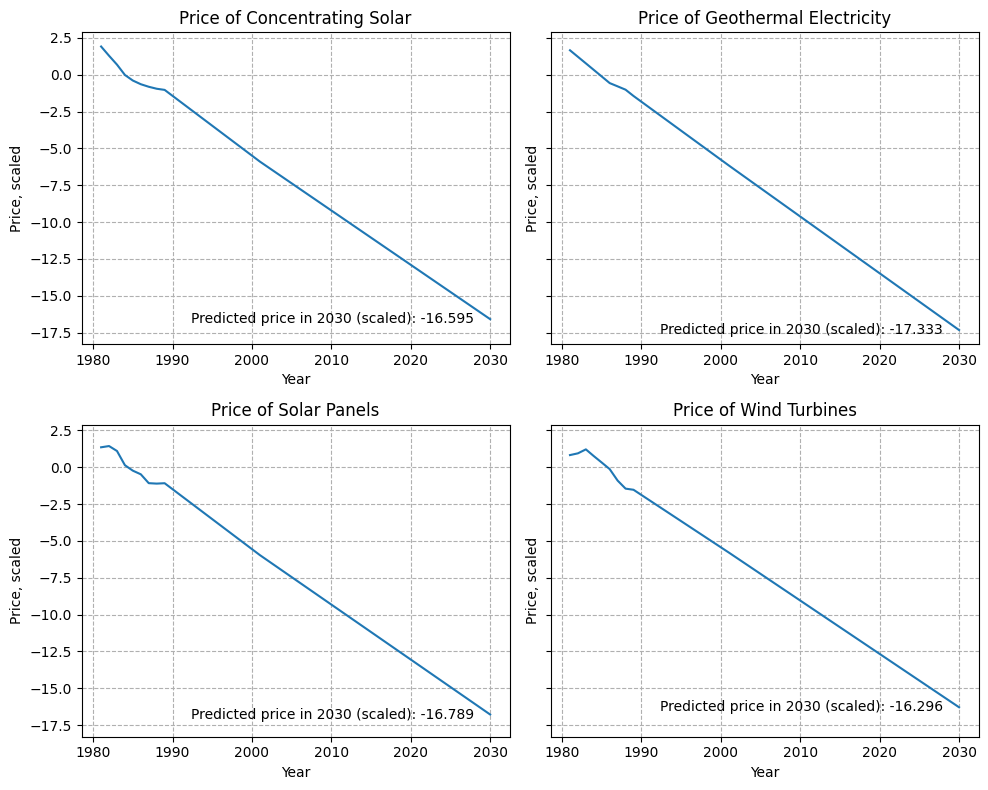

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8), sharey=True)

data = {
    "Concentrating Solar": scaled_predicted_df["Concentrating Solar"],
    "Geothermal Electricity": scaled_predicted_df["Geothermal Electricity"],
    "Solar Panels": scaled_predicted_df["Photovoltaics"],
    "Wind Turbines": scaled_predicted_df["Wind Turbine (Denmark)"],
}

positions = [(0, 0), (0, 1), (1, 0), (1, 1)]

for i, (label, values) in enumerate(data.items()):
    position = positions[i]
    ax = axs[position]
    ax.plot(scaled_predicted_df.index, values)
    ax.set_title("Price of " + label)
    ax.set_xlabel("Year")
    ax.set_ylabel("Price, scaled")
    ax.grid(linestyle="--")

    x_end = scaled_predicted_df.index[-1]
    y_end = values.iloc[-1]

    offset = 2
    ax.text(
        x_end - offset,
        y_end,
        f"Predicted price in 2030 (scaled): {y_end:.3f}",
        ha="right",
        va="center",
    )

plt.tight_layout()
plt.show()




# Conclusion:

We can see that in 2030 Concentrating Solar Energy is predicted to have the lowest price. 
However, they all end up very close to each other and they all show a magnificent lowering in price, ending up in the negatives. 

Offcourse, it is not realistic to think this will happen. Eventually the learning curve will flatten out. But it does show the following: 

* All true renewable energy sources have drastically lowered in price and will continue to do so for a while, ending up with prices lower than the current prices for fossil fuels.



# The end, my own personal opinion

After all of this I think the overall conclusion is that renewable energy is the way forward.
This can only work if we do more than encourage the individual to place a solar panel and eat less meat (remember: in the Netherlands the total energy used for electricity is less than 20%, a lot more needs to change than just our personal electricity use).

Sure, those things would absolutely help. But more important is that we change on a bigger scale. Countries need to make drastic changes on what they subsidize and laws need to be made based on realistic pledges.

CO2 emission needs to be lowered, not just compensated, the mindset on consumerism and food needs to change.


---


This assignment marks the end of my course and I am incredibly proud of what I have learned.

It has given me tools to work with and it has helped me learn pathways to focus, to see bigger and smaller pictures and to see patterns (or lack thereoff).


And not only have I learned a lot on data analysis: working on this last assignment has given me a better understanding of what is going on in the world and how we NEED TO CHANGE on a much deeper level than we think is good enough.

But it has shown me also change is possible. All is not lost, we can do this!

So thank you for that as well, Winc Academy! I am looking forward to changing my career and, hopefully, help change the world a little by focussing more on lowering my own footprint and helping others lower theirs.




---


# Data used for this analysis: 

* Hannah Ritchie, Max Roser and Pablo Rosado (2022) - "Energy". Published online at OurWorldInData.org. Retrieved from: https://ourworldindata.org/energy 

* Hannah Ritchie, Max Roser and Pablo Rosado (2020) - "CO₂ and Greenhouse Gas Emissions". Published online at OurWorldInData.org. Retrieved from: https://ourworldindata.org/co2-and-greenhouse-gas-emissions

* Hannah Ritchie, Pablo Rosado and Max Roser (2017) - "Meat and Dairy Production". Published online at OurWorldInData.org. Retrieved from: https://ourworldindata.org/meat-production

* Hannah Ritchie, Pablo Rosado and Max Roser (2022) - "Environmental Impacts of Food Production". Published online at OurWorldInData.org. Retrieved from: https://ourworldindata.org/environmental-impacts-of-food

* Max Roser, Hannah Ritchie and Edouard Mathieu (2023) - "Technological Change". Published online at OurWorldInData.org. Retrieved from: https://ourworldindata.org/technological-change